# LSTM _ENERGY PRODUCTİON
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N




In [17]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

df=pd.read_csv("Energy_Production.csv",index_col=0,parse_dates=True)
df.head()
df=df.dropna()
len(df)


325

<AxesSubplot:xlabel='DATE'>

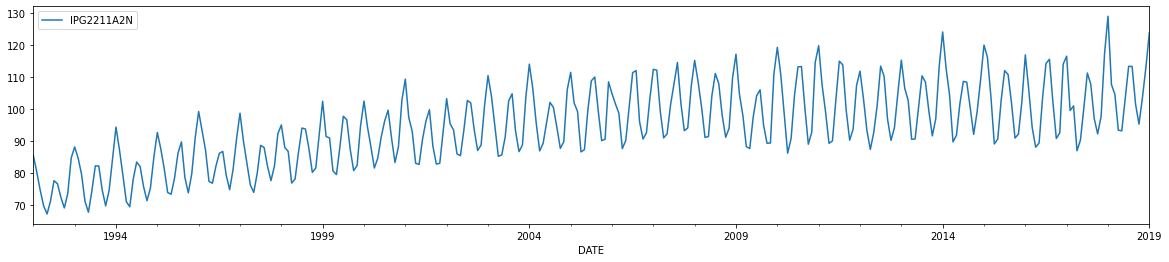

In [18]:
df.plot(figsize=(20,4))

In [19]:
df.head(13)

,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781
1992-06-01,71.4197
1992-07-01,77.7263
1992-08-01,76.7791
1992-09-01,72.5681


# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [21]:
# CODE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-window_size]
test_set = y[-window_size:]

In [22]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [24]:
# CODE HERE
scaler = MinMaxScaler(feature_range=(-1, 1))


train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [25]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [26]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [27]:
# CODE HERE

train_data = input_data(train_norm,window_size)

In [28]:
# Run the code below to check your results:
print(f'Train_data: {len(train_data)}')  # should equal 301

Train_data: 301


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [33]:
# CODE HERE
class LSTMnetwork(nn.Module):
    def __init__(self,input_dim=1,hidden_layer=64,output_dim=1):
        super().__init__()
        self.hidden_size=hidden_layer
        self.lstm=nn.LSTM(input_dim,hidden_layer)
        self.linear=nn.Linear(hidden_layer,output_dim)
        
        self.hidden=(torch.zeros(1,1,self.hidden_size),
                     torch.zeros(1,1,self.hidden_size))
    def forward(self,seq):
        lstm_out,self.hidden =self.lstm(seq.view((len(seq),1,-1),self.hidden))
        
        pred=self.linear(lstm_out.view(len(seq),-1))
        
        return pred[-1]


In [34]:
# Run the code below to check your results:
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [36]:
# CODE HERE
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)



### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [37]:
# CODE HERE
epochs=50
for epoch in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()
        model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        y_pred=model(seq)
        loss=criterion(y_pred,y_train)
        
        loss.backward()
        optimizer.step()
    print("Epoch {} of {} epochs Completed Loss {}".format(epoch,epochs,loss.item()))



Epoch 0 of 50 epochs Completed Loss 0.7314830422401428
Epoch 1 of 50 epochs Completed Loss 0.3222440779209137
Epoch 2 of 50 epochs Completed Loss 0.24065642058849335
Epoch 3 of 50 epochs Completed Loss 0.2275601625442505
Epoch 4 of 50 epochs Completed Loss 0.2115359902381897
Epoch 5 of 50 epochs Completed Loss 0.19906583428382874
Epoch 6 of 50 epochs Completed Loss 0.19067460298538208
Epoch 7 of 50 epochs Completed Loss 0.18480707705020905
Epoch 8 of 50 epochs Completed Loss 0.1796238124370575
Epoch 9 of 50 epochs Completed Loss 0.17441950738430023
Epoch 10 of 50 epochs Completed Loss 0.16898848116397858
Epoch 11 of 50 epochs Completed Loss 0.16325688362121582
Epoch 12 of 50 epochs Completed Loss 0.1573283076286316
Epoch 13 of 50 epochs Completed Loss 0.1513940840959549
Epoch 14 of 50 epochs Completed Loss 0.14566262066364288
Epoch 15 of 50 epochs Completed Loss 0.14030809700489044
Epoch 16 of 50 epochs Completed Loss 0.13544116914272308
Epoch 17 of 50 epochs Completed Loss 0.131103202

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [38]:
# CODE HERE
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq=torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())




In [39]:
# Run the code below to check your results:
preds[window_size:]

[0.2540278732776642,
 -0.002775205299258232,
 -0.342948317527771,
 -0.21167580783367157,
 0.23918868601322174,
 0.4891481399536133,
 0.24707989394664764,
 -0.08662214875221252,
 -0.25781765580177307,
 0.022585999220609665,
 0.5441880226135254,
 0.6110795140266418]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [40]:
# CODE HERE
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1)) #!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [41]:
# Run the code below to check your results:
true_predictions

array([[105.95764051],
       [ 98.0572222 ],
       [ 87.59196649],
       [ 91.63049961],
       [105.50112033],
       [113.19099795],
       [105.7438894 ],
       [ 95.4777129 ],
       [ 90.21096873],
       [ 98.83744697],
       [114.88427242],
       [116.94215571]])

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

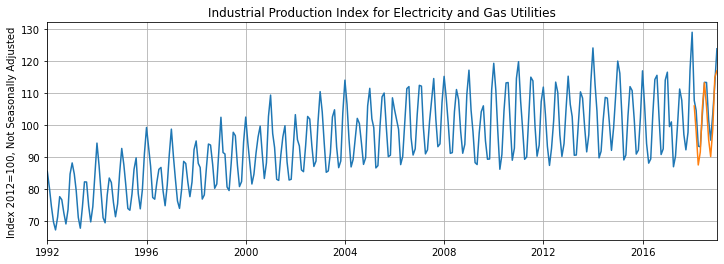

In [42]:
# CODE HERE
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

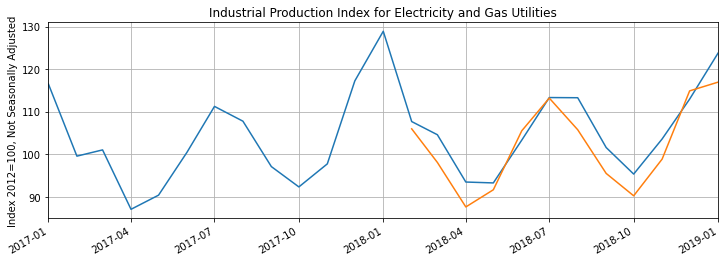

In [43]:
# CODE HERE TO DISPLAY THE END OF THE GRAPH
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()